In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.formula.api as smf

In [2]:
filepath = r"C:/Users/User/Downloads/reviews_Grocery_and_Gourmet_Food_5.json"
groc_revs_df = pd.read_json(filepath, lines=True)
groc_revs_df.head()

reviewerID        asin     reviewerName helpful  \
0  A1VEELTKS8NLZB  616719923X  Amazon Customer  [0, 0]   
1  A14R9XMZVJ6INB  616719923X          amf0001  [0, 1]   
2  A27IQHDZFQFNGG  616719923X          Caitlin  [3, 4]   
3  A31QY5TASILE89  616719923X     DebraDownSth  [0, 0]   
4  A2LWK003FFMCI5  616719923X         Diana X.  [1, 2]   

                                          reviewText  overall  \
0  Just another flavor of Kit Kat but the taste i...        4   
1  I bought this on impulse and it comes from Jap...        3   
2  Really good. Great gift for any fan of green t...        4   
3  I had never had it before, was curious to see ...        5   
4  I've been looking forward to trying these afte...        4   

                                             summary  unixReviewTime  \
0                                         Good Taste      1370044800   
1  3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2                                               Yum!      1381190400   
3                             Unexpected flavor meld      1369008000   
4  Not a very strong tea flavor, but still yummy ...      1369526400   

    reviewTime  
0   06 1, 2013  
1  05 19, 2014  
2   10 8, 2013  
3  05 20, 2013  
4  05 26, 2013

In [3]:
groc_revs_df = (groc_revs_df
                  .assign(date_stamp=pd.to_datetime(groc_revs_df.reviewTime))
                  .set_index('date_stamp')
                  )

groc_revs_df.head()

reviewerID        asin     reviewerName helpful  \
date_stamp                                                        
2013-06-01  A1VEELTKS8NLZB  616719923X  Amazon Customer  [0, 0]   
2014-05-19  A14R9XMZVJ6INB  616719923X          amf0001  [0, 1]   
2013-10-08  A27IQHDZFQFNGG  616719923X          Caitlin  [3, 4]   
2013-05-20  A31QY5TASILE89  616719923X     DebraDownSth  [0, 0]   
2013-05-26  A2LWK003FFMCI5  616719923X         Diana X.  [1, 2]   

                                                   reviewText  overall  \
date_stamp                                                               
2013-06-01  Just another flavor of Kit Kat but the taste i...        4   
2014-05-19  I bought this on impulse and it comes from Jap...        3   
2013-10-08  Really good. Great gift for any fan of green t...        4   
2013-05-20  I had never had it before, was curious to see ...        5   
2013-05-26  I've been looking forward to trying these afte...        4   

                                                      summary  unixReviewTime  \
date_stamp                                                                      
2013-06-01                                         Good Taste      1370044800   
2014-05-19  3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2013-10-08                                               Yum!      1381190400   
2013-05-20                             Unexpected flavor meld      1369008000   
2013-05-26  Not a very strong tea flavor, but still yummy ...      1369526400   

             reviewTime  
date_stamp               
2013-06-01   06 1, 2013  
2014-05-19  05 19, 2014  
2013-10-08   10 8, 2013  
2013-05-20  05 20, 2013  
2013-05-26  05 26, 2013

In [4]:
groc_by7day_df = (groc_revs_df
               .filter(items=["date_stamp", "overall"])
               .query("date_stamp > 2006")
               .resample("7d")
               .agg("mean")
               )

In [5]:
groc_by_hour_df = (groc_revs_df
                   .assign(hour=groc_revs_df.index.hour)
                   .groupby(['hour'])
                   .agg("mean")
                  )
groc_by_hour_df.head()

overall  unixReviewTime
hour                          
0     4.243042    1.342909e+09

No hour data is available

Text(0.5, 1.0, 'Review Average')

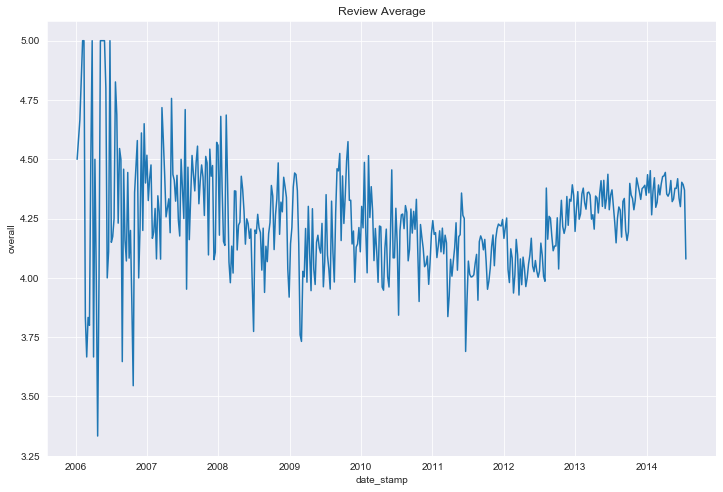

In [6]:
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=groc_by7day_df.index, y=groc_by7day_df["overall"], ax=ax, 
             legend="full", )
ax.set_title("Review Average")

In [56]:
def bander(df, sample):
    return (df
            .filter(items=['overall'])
            .resample(sample)
            .agg(['mean', 'std'])                
            # .rolling(30, center=True)  # rolling -> autocorrelation
            .droplevel(0, axis=1)
            .dropna()
            )
overall_band = bander(groc_revs_df, sample="7d")

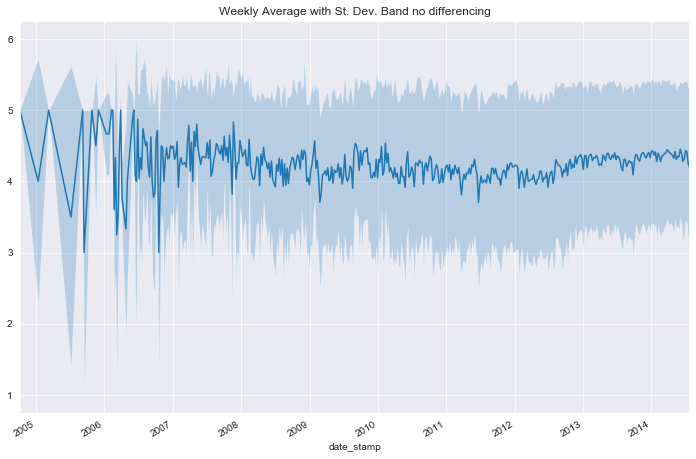

In [57]:
def plotter(df, fill):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    ax = df['mean'].plot()
    ax.fill_between(x=df.index, 
                    y1=df['mean'] - df['std'],
                    y2=df['mean'] + df['std'],
                    alpha=.25
                   )
    ax.set_title(label=f"Weekly Average with St. Dev. Band{fill}");
plotter(overall_band, fill=" no differencing")

In [62]:
overall_band.tail()

mean       std
date_stamp                    
2014-06-25  4.318352  1.083124
2014-07-02  4.431871  0.980048
2014-07-09  4.415211  0.991868
2014-07-16  4.256560  1.047725
2014-07-23  4.200000  1.788854

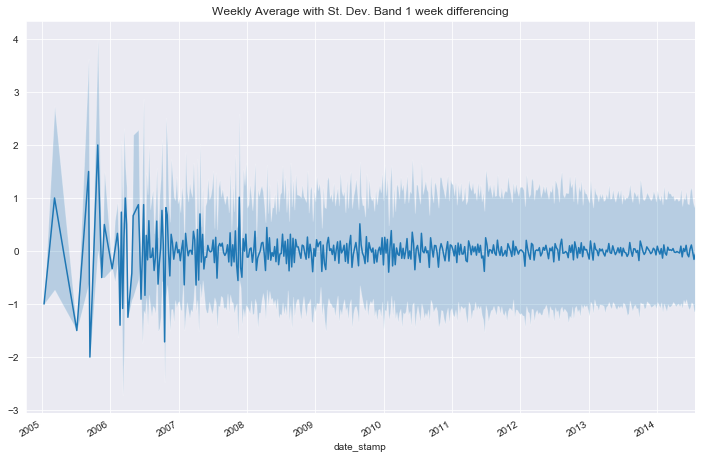

In [66]:
groc_diff1_df = overall_band.assign(mean=overall_band['mean'].diff(),
                                    std=overall_band['std'].shift())
                                    
plotter(groc_diff1_df, fill=" 1 week differencing")

This appears to be stationary. The variance appears to decrease, but the reduced fluctuation fo the mean does not accompany a decrease in the standard deviation, so it is only due to the increased sample size as time progresses.

This appears to not have a strong seasonal or trend component, but there may be autocorrelation.

In [34]:
groc_byday_df = (groc_revs_df[['overall']]
                 .groupby(groc_revs_df.index.weekday_name)
                 .agg({'overall': ['mean', "std"]})
                 .droplevel(0, axis=1)
                 .rename(columns={'mean': 'daily_mean', 'std': 'daily_std'})
                 .reset_index()
                 .assign(low_bound=lambda x: x.daily_mean - x.daily_std,
                         up_bound=lambda x: x.daily_mean + x.daily_std)
                )
groc_byday_df.head()

date_stamp  daily_mean  daily_std  low_bound  up_bound
0     Friday    4.286080   1.077748   3.208332  5.363828
1     Monday    4.265029   1.082579   3.182450  5.347608
2   Saturday    4.281745   1.091110   3.190635  5.372854
3     Sunday    4.287816   1.076388   3.211428  5.364204
4   Thursday    4.170857   1.097416   3.073441  5.268272

In [51]:
alt.data_transformers.disable_max_rows()

c = (alt
     .Chart(groc_revs_df.reset_index()[['date_stamp', 'overall']])
     .mark_errorbar(extent='stdev').encode(
         x='day(date_stamp):O',
         y='overall'
                            )
     .mark_circle().encode(
         x='day(date_stamp):O',
         y=alt.Y('overall', aggregate='mean', scale=alt.Scale(zero=False))))
c

alt.Chart(...)

# Time Series Modeling with Box-Jenkins
## Model Identification
### Augmented Dickey-Fuller unit root test
Tests for stationarity: Null hypothesis is that there is a unit root; alt is stationarity.
Lag number should be on the high side: too few lags lets serial correlation bias the test; too many reduces test power.

In [ ]:
adf_keys = dict.fromkeys(['test_stat', 'pvalue', 'lags_used', 'no_obs', 
                          'crit_vals_1_5_10', 'infocrit_best', 'resultstore'])
adf_result = {i: j for i, j in 
              zip(adf_keys, sm.tsa.stattools.adfuller(groc_byday_df.overall))}
adf_result

The very small p-value indicates that we can reject the h0 and conclude the time series is stationary. 
## Find model parameters


1.1 Differencing
Below are some tips during identification.

Unit Root Tests. Use unit root statistical tests on the time series to determine whether or not it is stationary. Repeat after each round of differencing.
Avoid over differencing. Differencing the time series more than is required can result in the addition of extra serial correlation and additional complexity.  

1.2 Configuring AR and MA
Two diagnostic plots can be used to help choose the p and q parameters of the ARMA or ARIMA. They are:

Autocorrelation Function (ACF). The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
Partial Autocorrelation Function (PACF). The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.
Both plots are drawn as bar charts showing the 95% and 99% confidence intervals as horizontal lines. Bars that cross these confidence intervals are therefore more significant and worth noting.

Some useful patterns you may observe on these plots are:

The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p.
The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.
The model is a mix of AR and MA if both the ACF and PACF trail off.

2. Estimation
Estimation involves using numerical methods to minimize a loss or error term.

We will not go into the details of estimating model parameters as these details are handled by the chosen library or tool.

I would recommend referring to a textbook for a deeper understanding of the optimization problem to be solved by ARMA and ARIMA models and optimization methods like Limited-memory BFGS used to solve it.

3. Diagnostic Checking
The idea of diagnostic checking is to look for evidence that the model is not a good fit for the data.

Two useful areas to investigate diagnostics are:

Overfitting
Residual Errors.
3.1 Overfitting
The first check is to check whether the model overfits the data. Generally, this means that the model is more complex than it needs to be and captures random noise in the training data.

This is a problem for time series forecasting because it negatively impacts the ability of the model to generalize, resulting in poor forecast performance on out of sample data.

Careful attention must be paid to both in-sample and out-of-sample performance and this requires the careful design of a robust test harness for evaluating models.

3.2 Residual Errors
Forecast residuals provide a great opportunity for diagnostics.

A review of the distribution of errors can help tease out bias in the model. The errors from an ideal model would resemble white noise, that is a Gaussian distribution with a mean of zero and a symmetrical variance.

For this, you may use density plots, histograms, and Q-Q plots that compare the distribution of errors to the expected distribution. A non-Gaussian distribution may suggest an opportunity for data pre-processing. A skew in the distribution or a non-zero mean may suggest a bias in forecasts that may be correct.

Additionally, an ideal model would leave no temporal structure in the time series of forecast residuals. These can be checked by creating ACF and PACF plots of the residual error time series.

The presence of serial correlation in the residual errors suggests further opportunity for using this information in the model.

In [ ]:
sarimax_mdl = statespace.sarimax.SARIMAX(
    endog=, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, 
                      measurement_error=False, time_varying_regression=False, mle_regression=True, 
                      simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True)